In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [44]:
lexeme_df = pd.read_parquet("../data/large_files/ruland-emlap-grela.parquet")

In [45]:
lexeme_df.loc[1780]

Lemma                                                 Lapis philosophorum
target_canonical                                      lapis philosophorum
entry_ids                                [Ruland1612-Lapis-philosophorum]
entry_count                                                             1
types                                                                 [L]
variants                                                               []
notes                                                                  []
senses_flat             [{'def': 'sein die Haar der Menschen.', 'entry...
sense_count                                                             1
sense_def_all                               [sein die Haar der Menschen.]
sense_def_strict_all                        [sein die Haar der Menschen.]
sense_raw_all                               [sein die Haar der Menschen.]
translations_all        [{'entry_id': 'Ruland1612-Lapis-philosophorum'...
target_relemmatized                   

In [46]:
emlap_metadata = pd.read_csv(
        "https://raw.githubusercontent.com/CCS-ZCU/EMLAP_ETL/refs/heads/master/data/emlap_metadata.csv",
        sep=";",
    )
emlap_metadata.head(5)

working_title  \
0        Augurello, Chrysopoeia   
1         Pseudo-Lull, Secretis   
2  Pantheus, Ars Transmutatione   
3          Anon, Vera alchemiae   
4        Pantheus, Voarchadumia   

                                           filenames     no.  is_done  \
0       100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1  100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2  100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
3            100004_Anon1561_Verae_Alchemiae_MDZ_MBS  100004     True   
4               100005_Pantheus1530_Voarchadumia_ONB  100005     True   

   is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  \
0         True        713324.0         NaN           True   
1        False             NaN         NaN           True   
2        False             NaN         NaN           True   
3        False             NaN         NaN           True   
4        False             NaN         NaN           True   

   #if more than 1 author skip section and choose compendium below  \
0                                                NaN                 
1                                                NaN                 
2                                                NaN                 
3                                                NaN                 
4                                                NaN                 

   is_author_known  ... publisher_comments CONTENTS                    genre  \
0             True  ...                NaN      NaN            didactic poem   
1             True  ...                NaN      NaN                 treatise   
2             True  ...                NaN      NaN                 treatise   
3             True  ...                NaN      NaN  compendium, florilegium   
4             True  ...                NaN      NaN                 treatise   

             subject SOURCE OF FILE  \
0            alchemy            NaN   
1  alchemy, medicine            NaN   
2            alchemy            NaN   
3            alchemy            NaN   
4            alchemy            NaN   

                                                link source_of_file  \
0       https://wiki.uibk.ac.at/noscemus/Chrysopoeia             GB   
1  https://www.digitale-sammlungen.de/en/view/bsb...            MDZ   
2  https://www.google.co.uk/books/edition/Ars_Tra...             GB   
3   https://mdz-nbn-resolving.de/details:bsb10141168            MDZ   
4                https://data.onb.ac.at/rep/10588E49            ONB   

   origin_of_copy  other_notes tokens_N  
0        Noscemus          NaN    23718  
1             MBS          NaN    24673  
2              BL          NaN     8646  
3             MBS          NaN     3521  
4             ONB          NaN    20386  

[5 rows x 54 columns]

In [47]:
emlap_metadata.columns

Index(['working_title', 'filenames', 'no.', 'is_done', 'is_noscemus',
       'if_noscemus_id', 'AUTHORSHIP', 'is_one_author',
       '#if more than 1 author skip section and choose compendium below',
       'is_author_known', 'author_name', 'author_name_alternatives',
       'author_viaf', 'author_cerl', 'author_comments', 'is_compendium',
       'if_compendium', 'TRANSLATION / EDITORSHIP', 'is_translator',
       'translator_name', 'translator_name_alternatives',
       'translator_comments', 'is_editor', 'editor_name',
       'editor_name_alternatives', 'editor_comments', 'DATE OF PUBLICATION',
       'date_publication', 'date_certainty', 'date_not_after',
       'date_not_before', 'date_comment', 'TITLE', 'title_short', 'title_full',
       'title_viaf', 'title_comments', 'PLACE OF PUBLICATION',
       'place_publication', 'place_geonames', 'place_comments', 'PUBLISHER',
       'publisher_name', 'publisher_name_alternatives', 'publisher_comments',
       'CONTENTS', 'genre', 'subjec

In [48]:
emlap_metadata["labeldate"] = emlap_metadata.apply(lambda row: row["working_title"] + " ({})".format(str(row["date_publication"])), axis=1)

In [49]:
emlap_metadata.sort_values("date_publication", ascending=True, inplace=True)

In [50]:
# emlap_id_label_dict = dict(zip(emlap_metadata["No."], emlap_metadata["labeldate"]))

In [57]:
def make_plot_bar(entry):
    # Get instance IDs for the entry
    instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
    counter = Counter(instances_ids)

    # Extract the keys (labels) and their corresponding counts (frequencies)
    emlap_metadata_instances = emlap_metadata.copy()
    emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int)
    )

    # Add bidecade labels to the DataFrame
    def get_bidecade_label(year):
        if not np.isnan(year):  # Handle NaN years safely
            start = (year // 20) * 20  # Determine the starting year of the bidecade
            end = start + 19  # Determine the ending year of the bidecade
            return f"{start}-{end}"
        return None

    emlap_metadata_instances["Bidecade"] = emlap_metadata_instances["date_publication"].apply(get_bidecade_label)

    # Group by Bidecade and sum frequencies and tokens_N
    emlap_instances_grouped = (
        emlap_metadata_instances.groupby("Bidecade", dropna=True)[["Frequency", "tokens_N"]]
        .sum()
        .reset_index()
    )

    # Sort bidecade intervals numerically
    emlap_instances_grouped = emlap_instances_grouped.sort_values(
        by="Bidecade",
        key=lambda col: col.str.extract(r"(\d+)")[0].astype(int)
    )

    # Calculate relative frequency (Frequency / tokens_N)
    emlap_instances_grouped["RelativeFrequency"] = (
        emlap_instances_grouped["Frequency"] / emlap_instances_grouped["tokens_N"]
    )

    # Calculate relative frequency for individual works
    emlap_metadata_instances["RelativeFrequency"] = (
        emlap_metadata_instances["Frequency"] / emlap_metadata_instances["tokens_N"]
    )

    # Create the 4 subplots (2x2 layout)
    fig, axes = plt.subplots(2, 2, figsize=(20, 15), dpi=300)

    # Plot 1: Absolute frequency vs. bidecades
    ax1 = axes[0, 0]
    ax1.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["Frequency"],
        color="blue"
    )
    ax1.set_xlabel("Bidecades", fontsize=12)
    ax1.set_ylabel("Absolute Frequency", fontsize=12)
    ax1.set_title(f"Absolute Frequency of '{entry}' by Bidecades", fontsize=14)
    ax1.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax1.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 2: Relative frequency vs. bidecades
    ax2 = axes[0, 1]
    ax2.bar(
        emlap_instances_grouped["Bidecade"],
        emlap_instances_grouped["RelativeFrequency"],
        color="orange"
    )
    ax2.set_xlabel("Bidecades", fontsize=12)
    ax2.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax2.set_title(f"Relative Frequency of '{entry}' by Bidecades", fontsize=14)
    ax2.set_xticks(range(len(emlap_instances_grouped["Bidecade"])))
    ax2.set_xticklabels(emlap_instances_grouped["Bidecade"], rotation=90)

    # Plot 3: Absolute frequency vs. works
    ax3 = axes[1, 0]
    ax3.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["Frequency"],
        color="green"
    )
    ax3.set_xlabel("Works", fontsize=12)
    ax3.set_ylabel("Absolute Frequency", fontsize=12)
    ax3.set_title(f"Absolute Frequency of '{entry}' by Works", fontsize=14)
    ax3.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax3.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90)

    # Plot 4: Relative frequency vs. works
    ax4 = axes[1, 1]
    ax4.bar(
        emlap_metadata_instances["labeldate"],
        emlap_metadata_instances["RelativeFrequency"],
        color="red"
    )
    ax4.set_xlabel("Works", fontsize=12)
    ax4.set_ylabel("Relative Frequency (Frequency / tokens_N)", fontsize=12)
    ax4.set_title(f"Relative Frequency of '{entry}' by Works", fontsize=14)
    ax4.set_xticks(range(len(emlap_metadata_instances["labeldate"])))
    ax4.set_xticklabels(emlap_metadata_instances["labeldate"], rotation=90)

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [53]:
entry = "Lapis philosophorum"
instances_ids = lexeme_df[lexeme_df["Lemma"] == entry]["instances_ids"].tolist()[0]
counter = Counter(instances_ids)
emlap_metadata_instances = emlap_metadata.copy()
emlap_metadata_instances["Frequency"] = (
        emlap_metadata_instances["no."].astype(str).map(counter).fillna(0).astype(int))

In [55]:
emlap_metadata_instances

working_title  \
0            Augurello, Chrysopoeia   
1             Pseudo-Lull, Secretis   
2      Pantheus, Ars Transmutatione   
8   Vegius, Inter inferiora corpora   
12                  Ulstadt, Coelum   
..                              ...   
97         Burggravius, Biolychnium   
95             Agricola, Galerazeya   
94    Fabre, Alchymista christianus   
96            Van Helmont, Opuscula   
99     Van Helmont, Ortus medicinae   

                                            filenames     no.  is_done  \
0        100001_Augurello1515_Chrysopoeia_GB_Noscemus  100001     True   
1   100002_Pseudo-Lull1518_De secretis_naturae_MDZ...  100002     True   
2   100003_Pantheus1518_Ars_Transmutationis_Metall...  100003     True   
8   100009_Vegius1518_Inter_inferiora_corpora_disp...  100009     True   
12  100013_Ulstad1525_Coelum_philosophorum_Medica_...  100013     True   
..                                                ...     ...      ...   
97       100098_Burggravius1630_Biolychnium_VD17_SLUB  100098     True   
95               100096_Agricola1631_Galerazeya_GB_BL  100096     True   
94        100095_Fabre1632_Alchymista_christianus_ONB  100095     True   
96     100097_Van_Helmont1644_Opuscula_medica_MDZ_MBS  100097     True   
99     100100_Van_Helmont1648_Ortus_medicinae_MDZ_MBS  100100     True   

    is_noscemus  if_noscemus_id  AUTHORSHIP  is_one_author  \
0          True        713324.0         NaN           True   
1         False             NaN         NaN           True   
2         False             NaN         NaN           True   
8         False             NaN         NaN          False   
12        False             NaN         NaN           True   
..          ...             ...         ...            ...   
97        False             NaN         NaN          False   
95        False             NaN         NaN           True   
94        False             NaN         NaN           True   
96        False             NaN         NaN           True   
99         True        688159.0         NaN           True   

    #if more than 1 author skip section and choose compendium below  \
0                                                 NaN                 
1                                                 NaN                 
2                                                 NaN                 
8                                                 NaN                 
12                                                NaN                 
..                                                ...                 
97                                                NaN                 
95                                                NaN                 
94                                                NaN                 
96                                                NaN                 
99                                                NaN                 

    is_author_known  ...                     genre  \
0              True  ...             didactic poem   
1              True  ...                  treatise   
2              True  ...                  treatise   
8             False  ...  treatise, dialogue, play   
12             True  ...                  treatise   
..              ...  ...                       ...   
97             True  ...                  treatise   
95             True  ...                  treatise   
94             True  ...                  treatise   
96             True  ...                  treatise   
99             True  ...                  treatise   

                        subject SOURCE OF FILE  \
0                       alchemy            NaN   
1             alchemy, medicine            NaN   
2                       alchemy            NaN   
8        Renaissance philosophy            NaN   
12        alchemy, quintessence            NaN   
..                          ...            ...   
97            alchemy, medicine            NaN   
95            alc

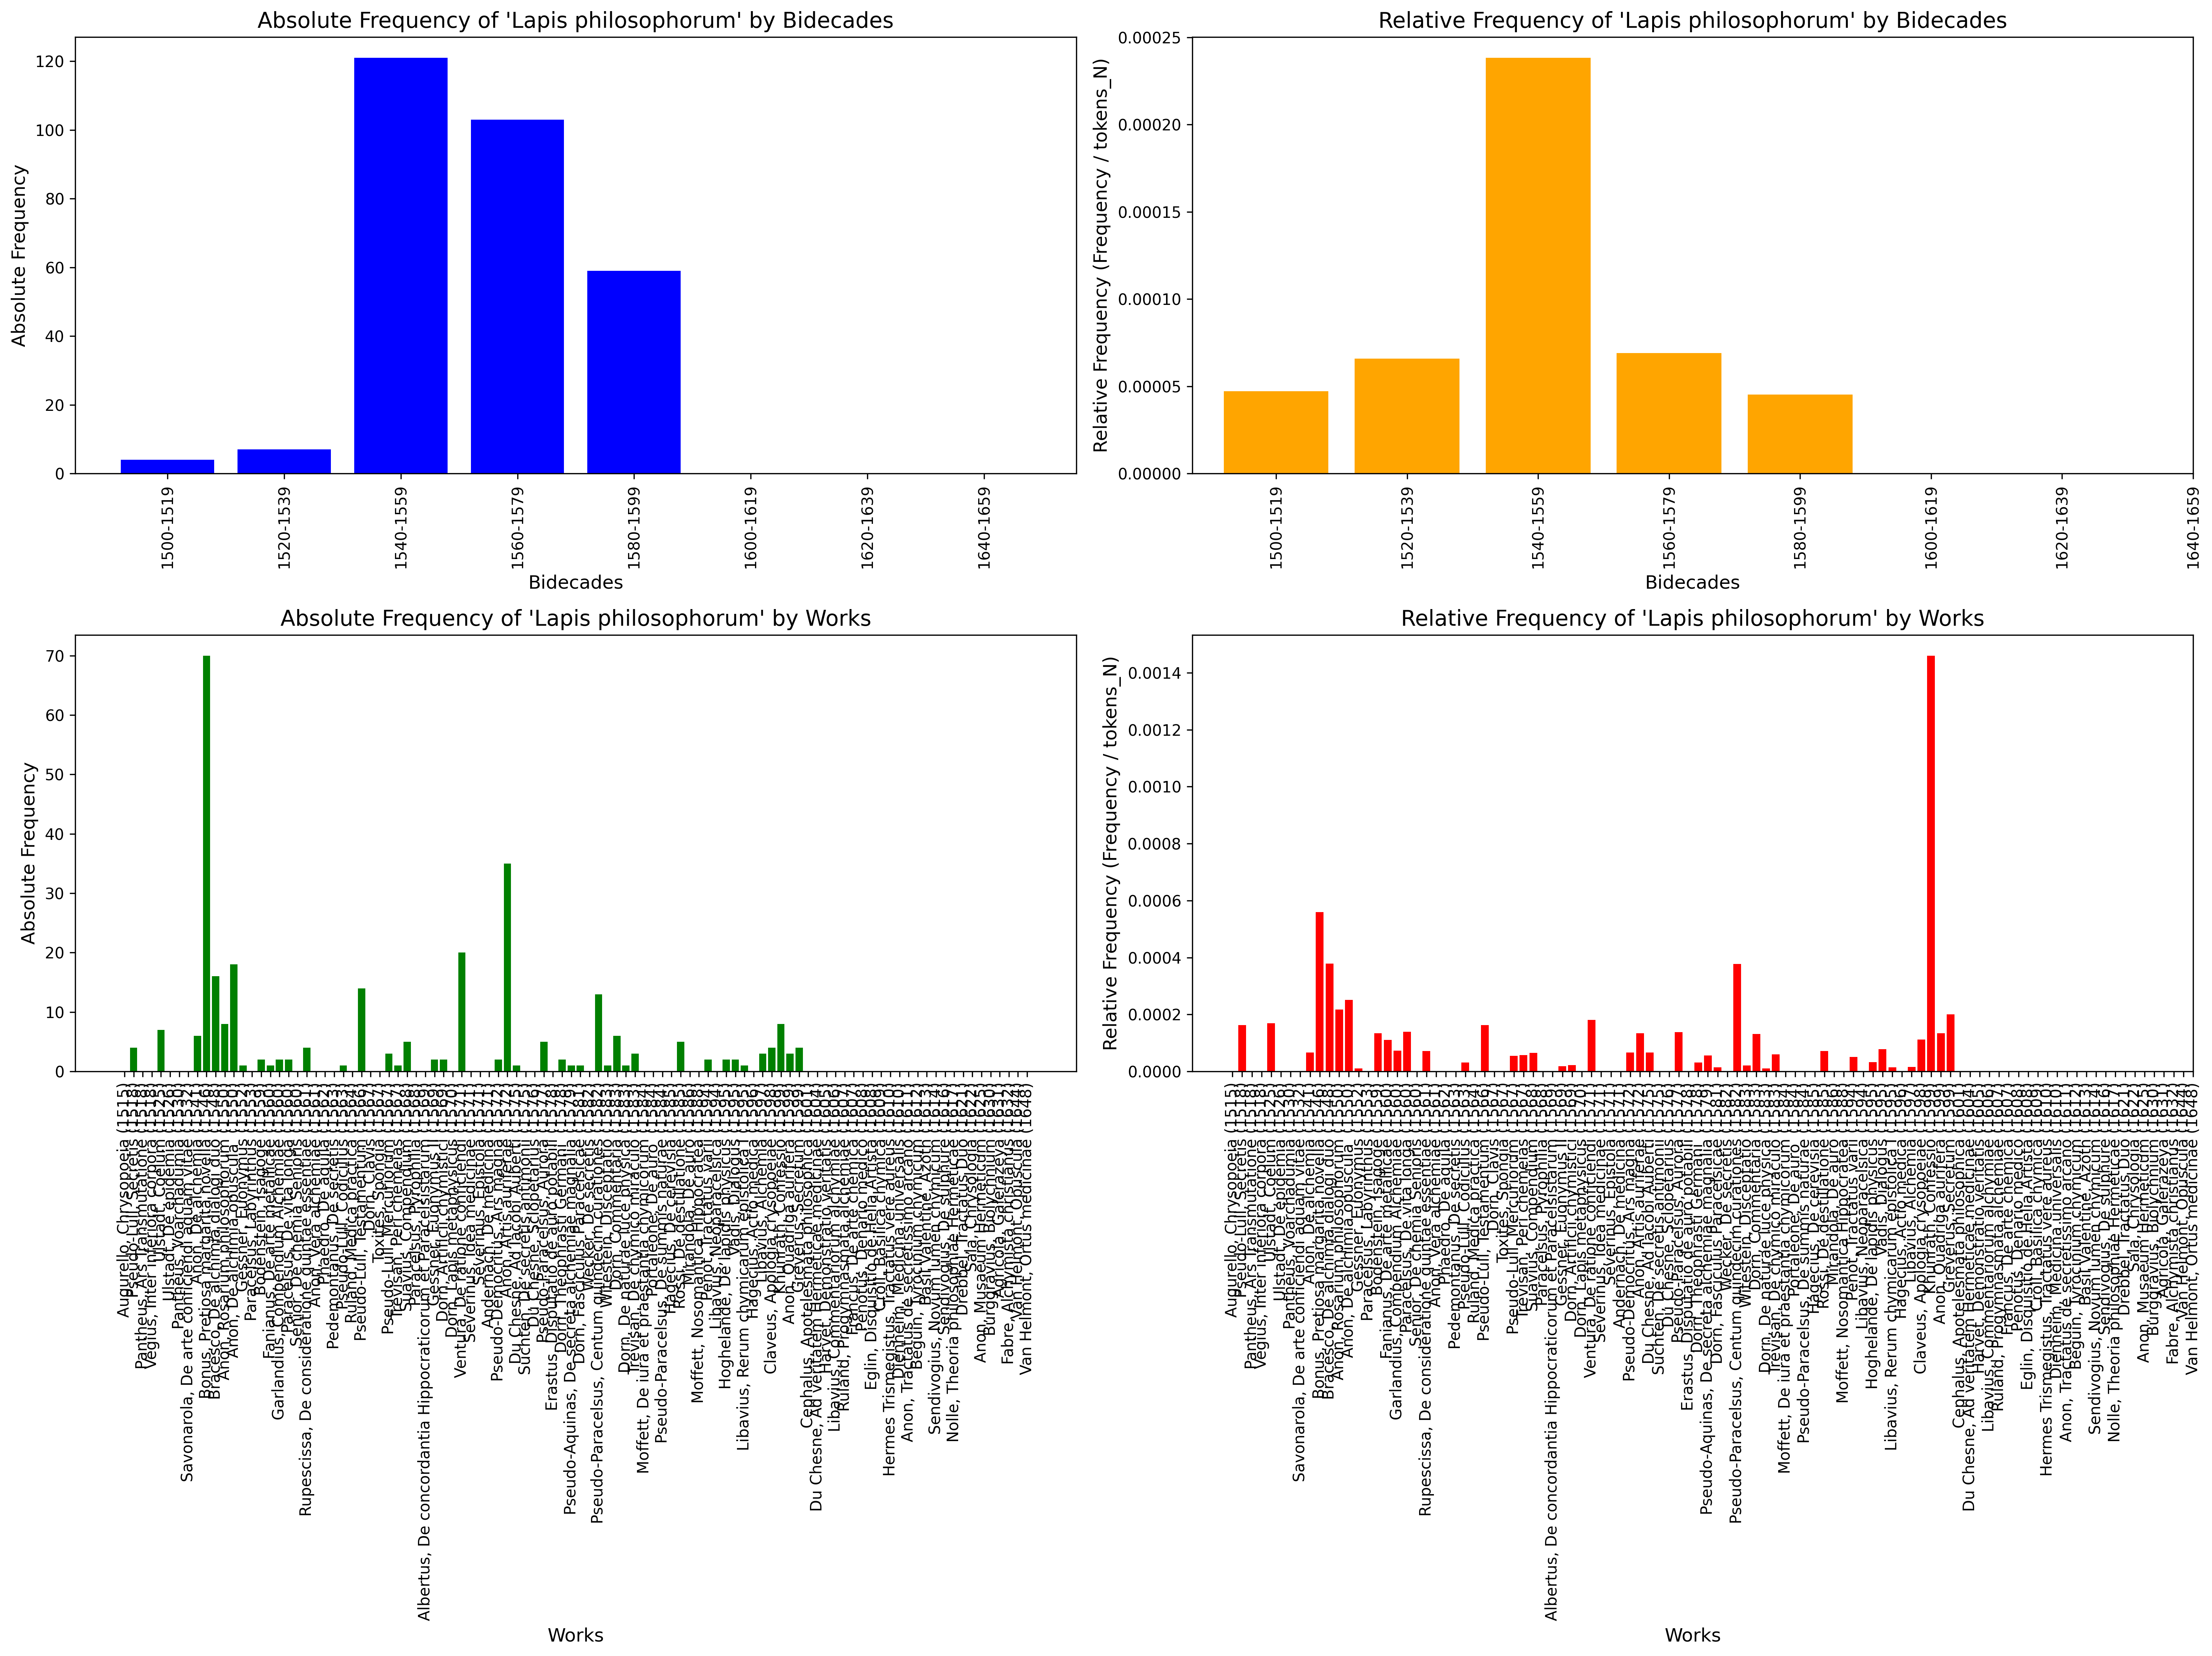

In [58]:
entry = "Lapis philosophorum"
make_plot_bar(entry)

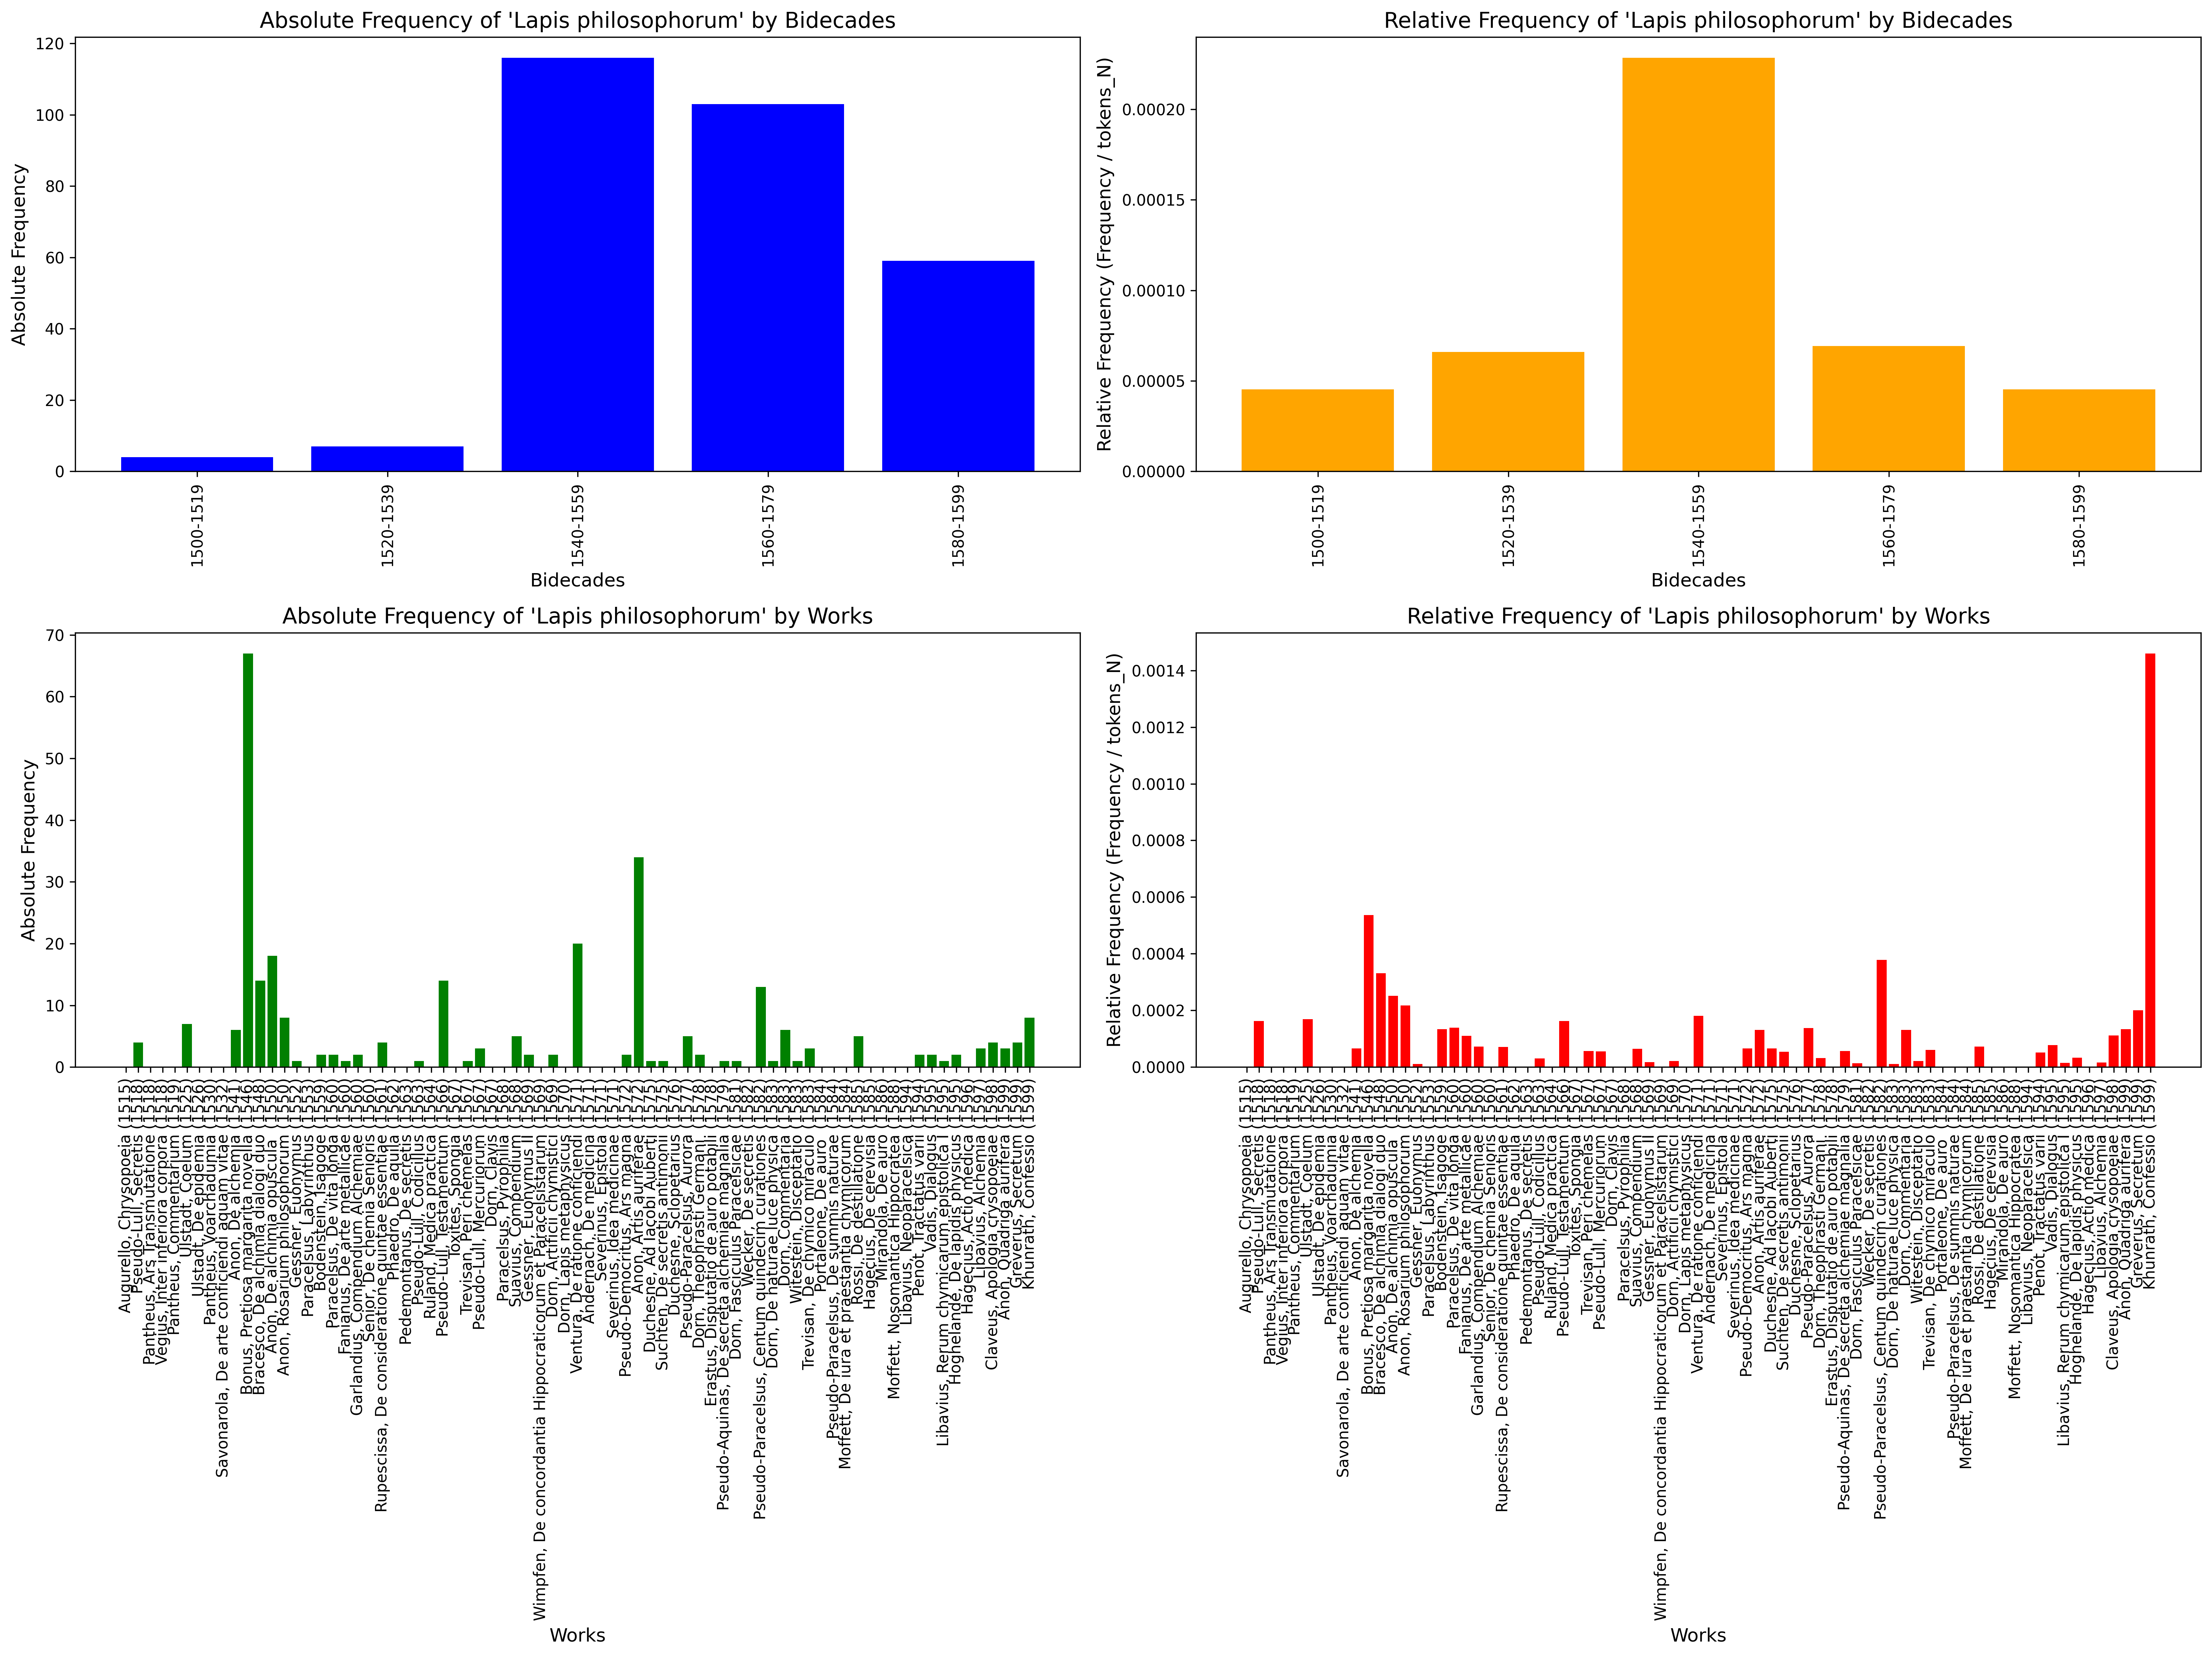

In [19]:
entry = "Lapis philosophorum"
make_plot_bar(entry)